In [3]:
!pip install rich
%load_ext rich

In [58]:
import builtins
import rich

builtins.print = rich.print

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("~/data/data/bike-sharing-demand/train.csv", parse_dates=["datetime"])

In [91]:
print(df.shape)

(10886, 12)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [93]:
def extract_datetime_features(df, column_name: str):
    df['year'] = df[column_name].apply(lambda x: x.year)
    df['month'] = df[column_name].apply(lambda x: x.month)
    df['day'] = df[column_name].apply(lambda x: x.day)
    df['hour'] = df[column_name].apply(lambda x: x.hour)
#     df['minute'] = df[column_name].apply(lambda x: x.minute)
#     df['second'] = df[column_name].apply(lambda x: x.second)    

extract_datetime_features(df, 'datetime')

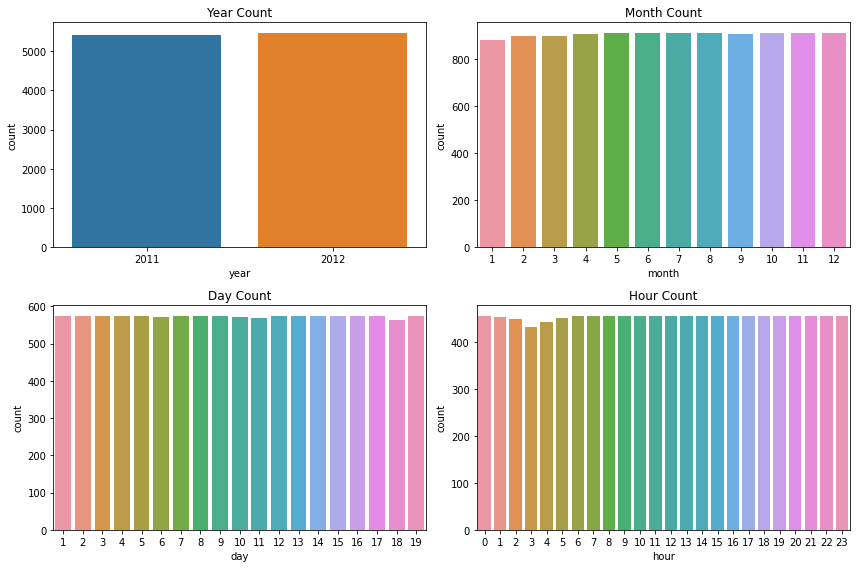

In [94]:
import seaborn as sns

# fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Year
sns.countplot(data=df, x='year', ax=axes[0, 0])
axes[0, 0].set_title('Year Count')

# Plot month count
sns.countplot(data=df, x='month', ax=axes[0, 1])
axes[0, 1].set_title('Month Count')

# Plot day count
sns.countplot(data=df, x='day', ax=axes[1, 0])
axes[1, 0].set_title('Day Count')

# Plot hour count
sns.countplot(data=df, x='hour', ax=axes[1, 1])
axes[1, 1].set_title('Hour Count')
# # Plot minute count
# sns.countplot(data=df, x='minute', ax=axes[1, 1])
# axes[1, 1].set_title('Minute Count')

# # Plot second count
# sns.countplot(data=df, x='second', ax=axes[1, 2])
# axes[1, 2].set_title('Second Count')

plt.tight_layout()
plt.show()

In [95]:
df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1


# Linear regression 4 assumptions
> https://www.statology.org/linear-regression-assumptions/

1. Linear relationship
2. **Independence**
3. Homoscedastictiy
4. Normality -> log

In [96]:
# count = casual + registered
df = df.drop(['datetime', 'casual', 'registered'], axis=1)

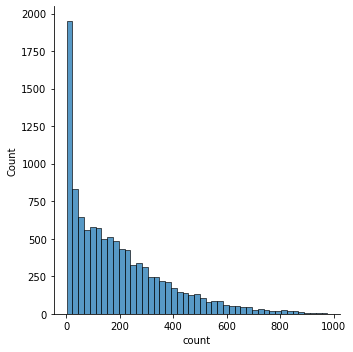

In [97]:
sns.displot(df['count'])

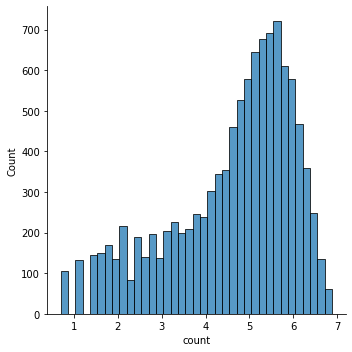

In [98]:
# log의 성질
#  - 0 < x < 1: 가파름, y값 넓게 펼칠 수 있음
#  - 1 <= x: 평탄, 매우 큰 x값에 대해 y값 큰 차이 없게 해줌
# 이를 통해 밀집된 부분은 퍼지게, 퍼져있는 부분은 모아지게
# https://suppppppp.github.io/posts/Why-Series-MDM-1/
sns.displot(np.log1p(df['count']))

In [99]:
df['count'] = np.log1p(df['count'])

# Train
1. Target 정규분포 확인
  - regression 큰 오류 원인, 분포 왜곡
  - 선형 회귀 모델은 종속 변수가 정규 분포를 따른다는 가정을 기반
  - 종속 변수가 왜곡된 분포를 가지고 있는 경우, 통계적 가정 신뢰성 타격, 통계적 추론 신뢰성 감소

2. Feature -> one-hot encoding

In [100]:
# log(x+1) to avoid x=0 -> -limit, overflow
# log1p <-> expm1
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['count'], axis=1), df['count'], test_size=0.3)

In [102]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7620, 12)

(3266, 12)

(7620,)

(3266,)

In [103]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)
print('RMSLE:', rmsle(y_test_exp, pred_exp))

RMSLE: 1.019634447167044

<AxesSubplot:>

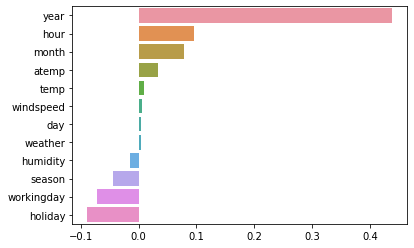

In [104]:
coef = pd.Series(lr_reg.coef_, index=X_train.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### year이 2021, 2022밖에 없는데 이렇게 강할 필요가 있는가? year도 지워버리자

In [111]:
from sklearn.metrics import mean_squared_error

df = pd.read_csv("~/data/data/bike-sharing-demand/train.csv", parse_dates=["datetime"])

def extract_datetime_features_withoud_year(df, column_name: str):
    # Year 사라짐
    df['month'] = df[column_name].apply(lambda x: x.month)
    df['day'] = df[column_name].apply(lambda x: x.day)
    df['hour'] = df[column_name].apply(lambda x: x.hour)

extract_datetime_features_withoud_year(df, 'datetime')

df = df.drop(['datetime', 'casual', 'registered'], axis=1)
df['count'] = np.log1p(df['count'])

# one-hot encoding
df = pd.get_dummies(df, columns=['month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['count'], axis=1),
    df['count'],
    test_size=0.3
)

# RMSLE
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# mse, rmse
def evaluate(y, pred):
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    return mse, rmse


# Linear Regression
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred_lr = lr_reg.predict(X_test)
mse_lr, rmse_lr = evaluate(np.expm1(y_test), np.expm1(pred_lr))
print('Linear Regression MSE:', mse_lr)
print('Linear Regression RMSE:', rmse_lr)
print('Linear Regression RMSLE:', rmsle(np.expm1(y_test), np.expm1(pred_lr)))

print("---")
# Ridge Regression
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
pred_ridge = ridge_reg.predict(X_test)
mse_ridge, rmse_ridge = evaluate(np.expm1(y_test), np.expm1(pred_ridge))
print('Ridge Regression MSE:', mse_ridge)
print('Ridge Regression RMSE:', rmse_ridge)
print('Ridge Regression RMSLE:', rmsle(np.expm1(y_test), np.expm1(pred_ridge)))

print("---")
# Lasso Regression
lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(X_train, y_train)
pred_lasso = lasso_reg.predict(X_test)
mse_lasso, rmse_lasso = evaluate(np.expm1(y_test), np.expm1(pred_lasso))
print('Lasso Regression MSE:', mse_lasso)
print('Lasso Regression RMSE:', rmse_lasso)
print('Lasso Regression RMSLE:', rmsle(np.expm1(y_test), np.expm1(pred_lasso)))

Linear Regression MSE: 12289.787674248579

Linear Regression RMSE: 110.85931478341628

Linear Regression RMSLE: 0.6336718141075365

---

Ridge Regression MSE: 12557.159919745007

Ridge Regression RMSE: 112.05873424122284

Ridge Regression RMSLE: 0.6348371382032576

---

Lasso Regression MSE: 15560.487193236895

Lasso Regression RMSE: 124.74168185990156

Lasso Regression RMSLE: 0.6769081664318819

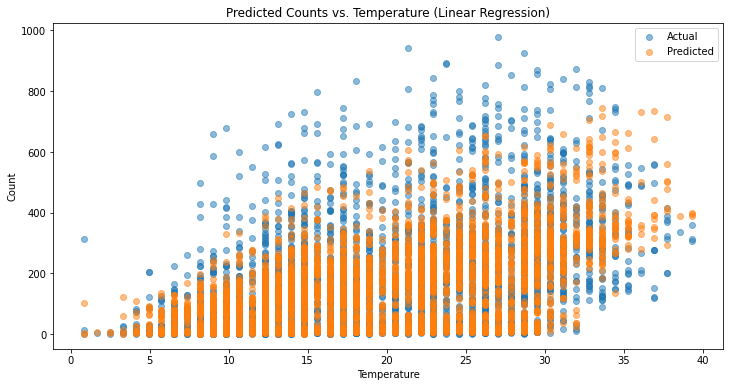

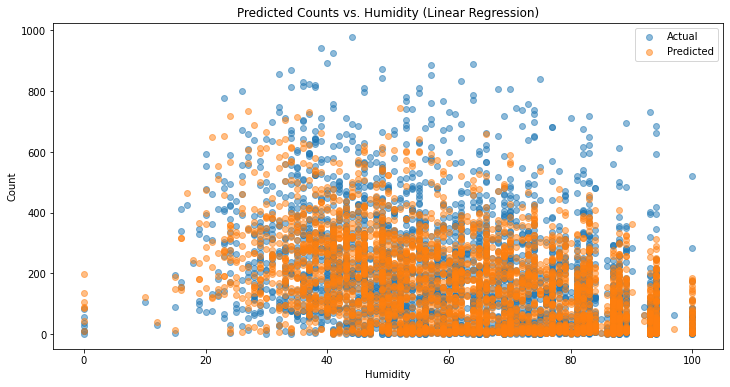

In [112]:

plt.figure(figsize=(12, 6))
plt.scatter(X_test['temp'], np.expm1(y_test), label='Actual', alpha=0.5)
plt.scatter(X_test['temp'], np.expm1(pred_lr), label='Predicted', alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.title('Predicted Counts vs. Temperature (Linear Regression)')
plt.legend()
plt.show()

# Scatter plot for humidity vs. count (Linear Regression)
plt.figure(figsize=(12, 6))
plt.scatter(X_test['humidity'], np.expm1(y_test), label='Actual', alpha=0.5)
plt.scatter(X_test['humidity'], np.expm1(pred_lr), label='Predicted', alpha=0.5)
plt.xlabel('Humidity')
plt.ylabel('Count')
plt.title('Predicted Counts vs. Humidity (Linear Regression)')
plt.legend()
plt.show()